In [2]:
# @title Imports
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# @title Load data
# clickings_cols = ['user_id', 'item_id', 'clicking']
clickings = pd.read_csv('/content/clickings.csv')

users = pd.read_csv('/content/users.csv')
users = users.reset_index(drop=True)

items_cols = ['title',
    '1_Blockchain', '2_DevOps', '3_Fintech', '4_Gaming', '5_AR/VR', '6_Machine Learning/AI', '7_IoT', '8_Voice skills',
    '9_Cybersecurity', '10_Communication', '11_Productivity', '12_Lifehacks', '13_Social Good', '14_COVID-19', '15_Music/Art',
    '16_Health', '17_Low/No Code', '18_Design', '19_Education', '20_E-commerce/Retail','21_Enterprise', '22_Open Ended',
    '23_Beginner Friendly', '24_Quantum', '25_Web', '26_Mobile', '27_Robotic Process Automation', '28_Databases']
items = pd.read_csv('/content/devpost_data_update5.csv')
items = items[items_cols]
items = items.reset_index(drop=True)

# Since the ids start at 1, we shift them to start at 0.
clickings["item_id"] = clickings["item_id"].apply(lambda x: str(x-1))
clickings["user_id"] = clickings["user_id"].apply(lambda x: str(x-1))

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [5]:
#@title Sparse Representation of Clicking Matrix
def build_clicking_sparse_tensor(clickings_df):
  """
  Args:
    clickings_df: a pd.DataFrame with `user_id`, `item_id` and `clicking` columns.
  Returns:
    a tf.SparseTensor representing the clickings matrix.
  """
  indices = clickings_df[['user_id', 'item_id']].values
  values = clickings_df['clicking'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[1000, 4104])

In [6]:
#@title Calculate Mean Square Error (MSE)
def sparse_mean_square_error(sparse_clickings, user_embeddings, item_embeddings):
  """
  Args:
    sparse_clickings: A SparseTensor clicking matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    item_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of item j.
  Returns:
    A scalar Tensor representing the MSE between the true clickings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, item_embeddings, transpose_b=True),
      sparse_clickings.indices)
  loss = tf.losses.mean_squared_error(sparse_clickings.values, predictions)
  return loss

In [7]:
# @title CFModel helper class
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [8]:
#@title Build a MF model and train it
def build_model(clickings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    clickings: a DataFrame of the clickings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the clickings DataFrame into train and test.
  train_clickings, test_clickings = split_dataframe(clickings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_clicking_sparse_tensor(train_clickings)
  A_test = build_clicking_sparse_tensor(test_clickings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 200: train_error=2.411748, test_error=13.943424

[{'train_error': 2.411748, 'test_error': 13.943424}]

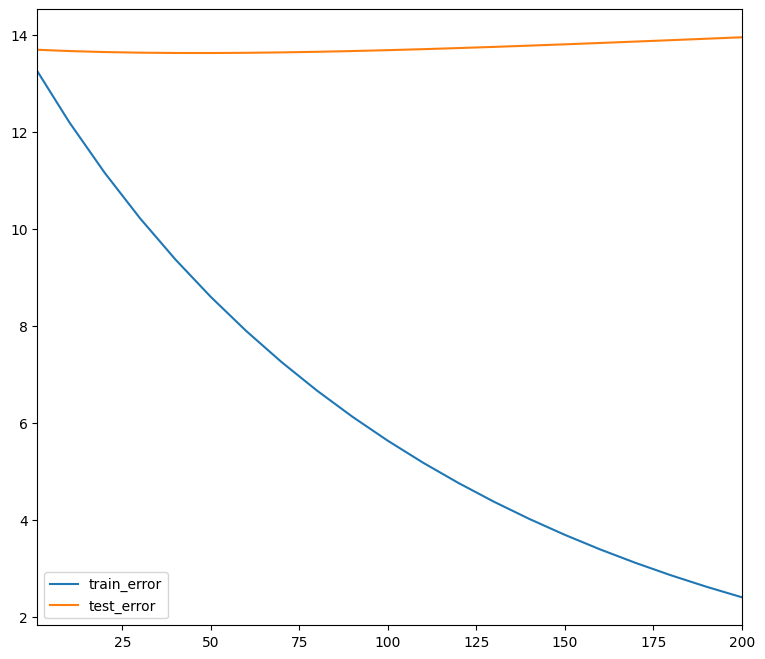

In [21]:
# Build the CF model and train it.
model = build_model(clickings, embedding_dim=40, init_stddev=0.5)
model.train(num_iterations=200, learning_rate=1)

In [9]:
# @title Regularization
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    clickings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    clickings: the DataFrame of itemclickings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the clickings DataFrame into train and test.
  train_clickings, test_clickings = split_dataframe(clickings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_clicking_sparse_tensor(train_clickings)
  A_test = build_clicking_sparse_tensor(test_clickings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "item_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 200: train_error_observed=0.094505, test_error_observed=10.543421, observed_loss=0.094505, regularization_loss=0.797002, gravity_loss=0.401606

[{'train_error_observed': 0.09450536, 'test_error_observed': 10.543421},
 {'observed_loss': 0.09450536,
  'regularization_loss': 0.79700154,
  'gravity_loss': 0.4016057}]

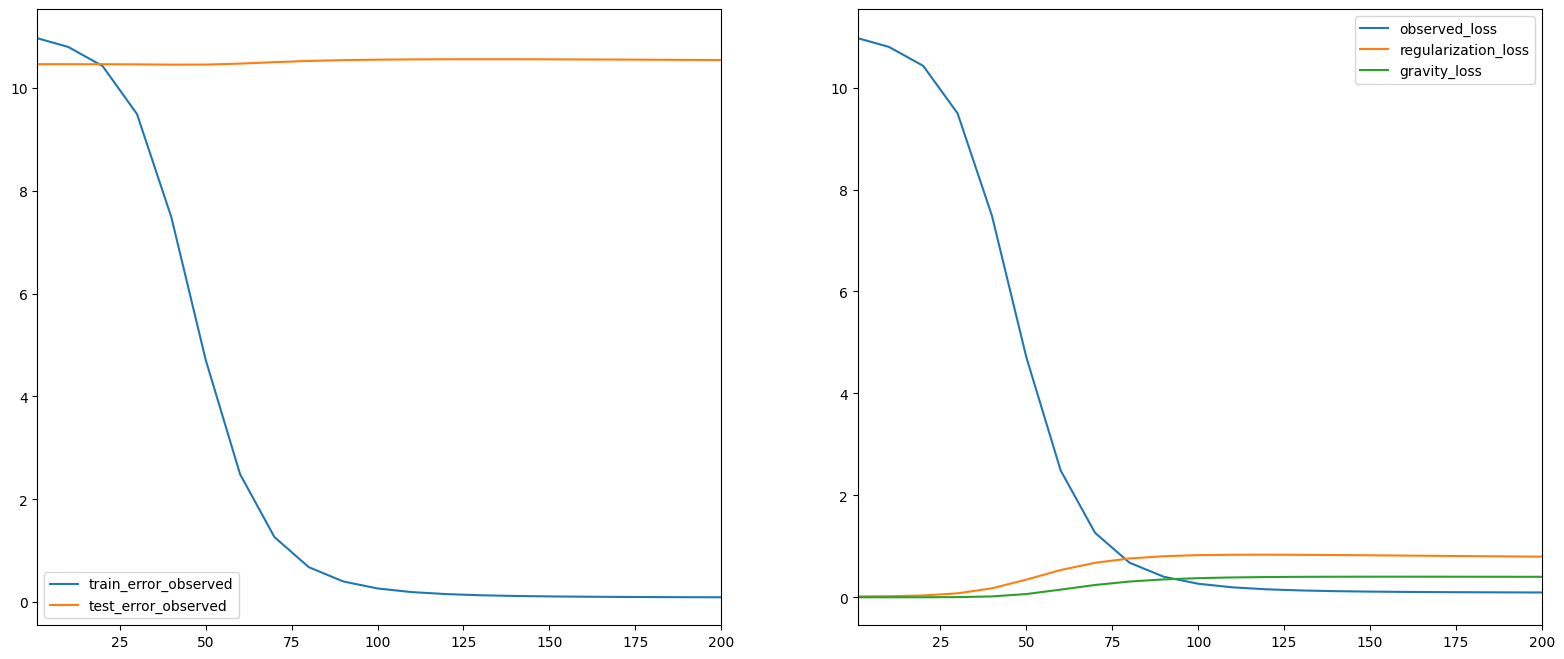

In [10]:
reg_model = build_regularized_model(
    clickings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=200, learning_rate=20.)

In [11]:
#@title Compute recommendation scores
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [12]:
# @title User recommendations
def user_recommendations(model, user_id, measure=DOT, k=5):
    scores = compute_scores(
        model.embeddings["user_id"][user_id], model.embeddings["item_id"], measure)
    score_key = measure + ' score'
    print(len(model.embeddings["item_id"]))
    df = pd.DataFrame({
        score_key: list(scores),
        'titles': items['title'],
    })
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [15]:
user_recommendations(reg_model, 999, DOT, k=5)

4104


,dot score,titles
262,5.488,Hacktara
902,4.526,Luna Hacks 2.0
3896,3.566,"Web Hack 2019 || HTML CSS, WordPress"
3087,3.167,CrimsonCode Hackathon IX
3043,3.023,Beyond Code
